<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

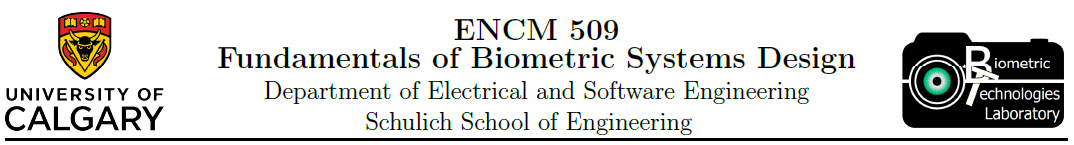

## Introduction 

Gesture recognition is gaining popularity as a biometric. Compared to other traditional biomterics (e.g. fingerprints), gesture recognition can capture unique behaviour patterns in an individual's hand signals. The data captured in these cases can be much more complex that other biomterics, therefore it is useful to employ more sophisticased classification models. One example of this is a long short-term memory (LSTM) deep learning model.   

The purpose of this lab is to implement an LSTM deep learning model for the time series data acquired from the Leap Motion devices. In addition, this lab will also investigate the different parameters involved in a deep neural network, including the test/train split, number of nodes, and dropout. Together these purposes will provide a deeper understanding of the architecture in a neural network, as well as ways in which the model can be refined. 


In [1]:
import pandas as pd
import numpy as np

#!pip install tensorflow
import tensorflow as tf

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 100
# the number of features (from the data)
NUMBER_FEATURES = 202
# the number of classes/gestures
NUMBER_OUTPUTS = 2
# you can encode more than 1 but for this example we have binary output (circle/swipe)

In [3]:
# the directory where your data is
mypath = './leap_motion_data'

# creating a list with all the filenames
datafiles = [f for f in listdir('leap_motion_data') if isfile(join(mypath, f))]

In [4]:
# choose data we need
columns = ['handPalmPosition_X','handPalmPosition_Y','handPalmPosition_Z',
          'pitch', 'roll', 'yaw', 'GestureTypeCircle', 'GestureTypeSwipe',
          'wristPosition_X', 'wristPosition_Y','wristPosition_Z',
          'elbowPosition_X', 'elbowPosition_Y', 'elbowPosition_Z']

finger_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
bone_names = ['Metacarpal', 'Proximal', 'Intermediate', 'Distal']
    
for finger in finger_names:
    columns.append(finger + 'Length')
    columns.append(finger + 'Width')

for finger in finger_names:
    for bone in bone_names:
        columns.append(finger + bone + 'Start_X')
        columns.append(finger + bone + 'Start_Y')
        columns.append(finger + bone + 'Start_Z')
        columns.append(finger + bone + 'End_X')
        columns.append(finger + bone + 'End_Y')
        columns.append(finger + bone + 'End_Z')
        columns.append(finger + bone + 'Direction_X') 
        columns.append(finger + bone + 'Direction_Y') 
        columns.append(finger + bone + 'Direction_Z')   

# Preprocessing for pre-recorded data

In [5]:
# Features
x = []
# Labels
y = []
num=1
for sample in datafiles:
    relative_path = './leap_motion_data/' + sample
    tmp = pd.read_csv(relative_path, usecols=columns)
    
    # Normalize the sample size: LSTM requires all inputs of the same size!
    print('{}\nsize raw = {}'.format(relative_path,tmp.shape))
    while tmp.shape[0] < NUMBER_TIMESTEPS:
        # tmp = tmp.append(pd.Series(0, index=tmp.columns), ignore_index=True)
        tmp = tmp.reindex(range(NUMBER_TIMESTEPS), fill_value=0)
        print ( tmp.shape[0])
    print('END')

    if tmp.shape[0] > NUMBER_TIMESTEPS:
        tmp = tmp.head(100)
    print('size normalized = ',tmp.shape)
    
    tmp_x = tmp[[column for column in list(tmp.columns)
                 if column != 'GestureTypeCircle' 
                 and column != 'GestureTypeSwipe']]
    tmp_y = tmp[['GestureTypeCircle', 'GestureTypeSwipe']]
    path_str = 'save/'+ str(num) +'.csv'
    # tmp_x.to_csv(path_str)  
    num = num+1
    x.append(tmp_x)
    y.append(tmp_y)

./leap_motion_data/circle1.csv
size raw = (37, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle10.csv
size raw = (60, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle2.csv
size raw = (66, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle3.csv
size raw = (39, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle4.csv
size raw = (39, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle5.csv
size raw = (78, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle6.csv
size raw = (129, 204)
END
size normalized =  (100, 204)
./leap_motion_data/circle7.csv
size raw = (80, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle8.csv
size raw = (97, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/circle9.csv
size raw = (67, 204)
100
END
size normalized =  (100, 204)
./leap_motion_data/swipe1.csv
size raw = (84, 204)
100
END
size normalized =  (100, 204)
./leap_motion

## Exercise 1 - Test/Train Split

In [6]:
np.array(y[0].loc[0])

array([1, 0], dtype=int64)

In [7]:
# Each sample requires labels of [1,NUMBER_OUTPUTS] size (not a list)
y_new = list()
for cur_label in y:
    tmp = np.array(cur_label.loc[0])
    y_new.append(tmp)
y = np.array(y_new)
#print(y)

In [8]:
test_sizes = [0.2, 0.4]
#Creating two training/testing sets of data
#Set 1 - Training = 0.8, Testing = 0.2
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, shuffle = True)
#Set 2 - Training = 0.6, Testing = 0.4
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size = 0.4, shuffle = True)

len_train1 = len(X_train1)
len_train2 = len(X_train2)

len_test1 = len(X_test1)
len_test2 = len(X_test2)

print ('Number of train samples = {}\nNumber of test samples = {}'. format(len_train1, len_test1))
print ('There is ',type(X_train1),' of ',type(X_train1[0]))
    
X_train1 = np.array(X_train1)
X_test1 = np.array(X_test1)
print('The list was turned into <numpy.ndarray>\n ')

print ('Number of train samples = {}\nNumber of test samples = {}'. format(len_train2, len_test2))
print ('There is ',type(X_train2),' of ',type(X_train2[0]))
    
X_train2 = np.array(X_train2)
X_test2 = np.array(X_test2)
print('The list was turned into <numpy.ndarray>\n ')


Number of train samples = 16
Number of test samples = 4
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>
 
Number of train samples = 12
Number of test samples = 8
There is  <class 'list'>  of  <class 'pandas.core.frame.DataFrame'>
The list was turned into <numpy.ndarray>
 


In [9]:
def build_model():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

In [10]:
# creating the model - to reduce bias, two separate models are built for each test_train_split
model_1 = build_model()

model_2 = build_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          470016    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               

In [11]:
print("Training the model with testing split of {}%". format(test_sizes[0]*100))
model_1.fit(X_train1, y_train1, epochs=10, batch_size=len_train1)

print("\nTraining the model with testing split of {}%". format(test_sizes[1]*100))
model_2.fit(X_train2, y_train2, epochs=10, batch_size=len_train2)


Training the model with testing split of 20.0%
Epoch 1/10


1/1 [==============================] - 4s 4s/step - loss: 0.6989 - accuracy: 0.4375
Epoch 2/10
1/1 [==============================] - 0s 299ms/step - loss: 0.6593 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 305ms/step - loss: 0.5825 - accuracy: 0.5625
Epoch 4/10
1/1 [==============================] - 0s 326ms/step - loss: 0.5260 - accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 330ms/step - loss: 0.4769 - accuracy: 0.5625
Epoch 6/10
1/1 [==============================] - 0s 308ms/step - loss: 0.3241 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 313ms/step - loss: 0.1173 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 345ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 338ms/step - loss: 6.1624e-04 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 328ms/step - l

In [12]:
print("Testing the model with testing split of {}%". format(test_sizes[0]*100))
test_loss, test_acc = model_1.evaluate(X_test1, y_test1, batch_size=len_train1)

print("\nTesting the model with testing split of {}%". format(test_sizes[1]*100))
test_loss, test_acc = model_2.evaluate(X_test2, y_test2, batch_size=len_train2)

Testing the model with testing split of 20.0%
1/1 [==============================] - 2s 2s/step - loss: 4.4703e-07 - accuracy: 1.0000

Testing the model with testing split of 40.0%
1/1 [==============================] - 2s 2s/step - loss: 2.9782 - accuracy: 0.7500


In [13]:
#Evaluating the predictive capabilities of each test/train split
#Testing split = 0.2, Training split = 0.8
print("Testing the model with testing split of {}%". format(test_sizes[0]*100))
y_pred_1 = model_1.predict(X_test1)
predicted_labels_1 = np.argmax(y_pred_1, axis = 1)
true_labels_1 = np.argmax(y_test1, axis = 1)

matches_1 = (predicted_labels_1 == true_labels_1)
print('Total of matches: %d' % (matches_1.sum()))

match_rate_1 = matches_1.sum() / float(len(matches_1))
print('Match rate: %.2f\n' % (match_rate_1))

#Testing split = 0.4, training split = 0.6
print("Testing the model with testing split of {}%". format(test_sizes[1]*100))
y_pred_2 = model_2.predict(X_test2)

predicted_labels_2 = np.argmax(y_pred_2, axis=1)
true_labels_2 = np.argmax(y_test2, axis =1)

matches_2 = (predicted_labels_2 == true_labels_2)
print('Total of matches: %d' % (matches_2.sum()))

match_rate_2 = matches_2.sum() / float(len(matches_2))
print('Match rate: %.2f' % (match_rate_2))        


Testing the model with testing split of 20.0%
1/1 [==============================] - 2s 2s/step
Total of matches: 4
Match rate: 1.00

Testing the model with testing split of 40.0%
1/1 [==============================] - 1s 1s/step
Total of matches: 6
Match rate: 0.75


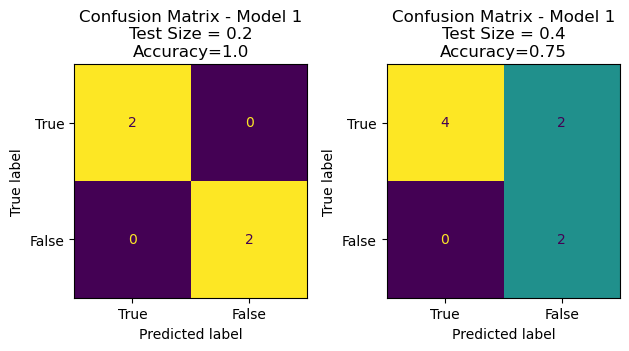

In [14]:
#Creating a confusion matrix to visualize the results
cm_1 = confusion_matrix(predicted_labels_1, true_labels_1)
cm_2 = confusion_matrix(predicted_labels_2, true_labels_2)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Confusion Matrix - Model 1\nTest Size = 0.2\nAccuracy={}".format(match_rate_1))
ax[1].set_title("Confusion Matrix - Model 1\nTest Size = 0.4\nAccuracy={}".format(match_rate_2))
ConfusionMatrixDisplay(cm_1, display_labels=[True, False]).plot(ax=ax[0], colorbar = False)
ConfusionMatrixDisplay(cm_2, display_labels=[True, False]).plot(ax=ax[1], colorbar = False)
plt.tight_layout()
plt.show()


**Analysis**  

Based on the test above, as the training split is decreased (where training split = 1 - test split), the model accuracy generally decreases. This is expected since a larger training split means that the model uses more data to train the parameters. When this is applied to the testing set (with unseen data), this results in better accuracy. 

Looking at the confusion matrix obtained for the 80/20 split (left), we see that the model performs very well and is able to correctly classify all 4 test samples. In the case of the 60/40 split (right), 6 of 8 test samples were correctly classified, with 2 instances of false positives (i.e. where the model predicted a gesture to be true when it was in fact false).

### Exercise 2 - Reduced Nodes

In [15]:
#Building a model with a reduced amount of nodes
#128 nodes input layers / 256, 128, 256, hidden layer 
def build_alt_model_1():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(128, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(128, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(256,activation='relu'))  
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128,activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

In [16]:
model_3 = build_alt_model_1()
model_4 = build_alt_model_1()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 128)          169472    
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)              

In [17]:
print("Training the model with testing split of {}%". format(test_sizes[0]*100))
model_3.fit(X_train1, y_train1, epochs=10, batch_size=len_train1)

print("\nTraining the model with testing split of {}%". format(test_sizes[1]*100))
model_4.fit(X_train2, y_train2, epochs=10, batch_size=len_train2)


Training the model with testing split of 20.0%
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 0.6949 - accuracy: 0.6875
Epoch 2/10
1/1 [==============================] - 0s 121ms/step - loss: 0.6820 - accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 94ms/step - loss: 0.6756 - accuracy: 0.5625
Epoch 4/10
1/1 [==============================] - 0s 87ms/step - loss: 0.6407 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 92ms/step - loss: 0.6286 - accuracy: 0.6250
Epoch 6/10
1/1 [==============================] - 0s 87ms/step - loss: 0.5671 - accuracy: 0.6250
Epoch 7/10
1/1 [==============================] - 0s 103ms/step - loss: 0.5571 - accuracy: 0.7500
Epoch 8/10
1/1 [==============================] - 0s 83ms/step - loss: 0.4441 - accuracy: 0.7500
Epoch 9/10
1/1 [==============================] - 0s 119ms/step - loss: 0.3386 - accuracy: 0.8750
Epoch 10/10
1/1 [==============================] - 0s 110ms/step - loss: 0.2385

In [18]:
print("Testing the model with testing split of {}%". format(test_sizes[0]*100))
test_loss, test_acc = model_3.evaluate(X_test1, y_test1, batch_size=len_train1)

print("\nTesting the model with testing split of {}%". format(test_sizes[1]*100))
test_loss, test_acc = model_4.evaluate(X_test2, y_test2, batch_size=len_train2)


Testing the model with testing split of 20.0%
1/1 [==============================] - 2s 2s/step - loss: 1.4791 - accuracy: 0.7500

Testing the model with testing split of 40.0%
1/1 [==============================] - 2s 2s/step - loss: 0.4307 - accuracy: 0.7500


In [19]:
#Evaluating the predictive capabilities of each test/train split
#Testing split = 0.2, Training split = 0.8
print("Testing the model with testing split of {}%". format(test_sizes[0]*100))
y_pred_3 = model_3.predict(X_test1)
predicted_labels_3 = np.argmax(y_pred_3, axis = 1)
true_labels_3 = np.argmax(y_test1, axis = 1)

matches_3 = (predicted_labels_3 == true_labels_3)
print('Total of matches: %d' % (matches_3.sum()))

match_rate_3 = matches_3.sum() / float(len(matches_3))
print('Match rate: %.2f\n' % (match_rate_3))

#Testing split = 0.4, training split = 0.6
print("Testing the model with testing split of {}%". format(test_sizes[1]*100))
y_pred_4 = model_4.predict(X_test2)
predicted_labels_4 = np.argmax(y_pred_4, axis=1)
true_labels_4 = np.argmax(y_test2, axis =1)

matches_4 = (predicted_labels_4 == true_labels_4)
print('Total of matches: %d' % (matches_4.sum()))

match_rate_4 = matches_4.sum() / float(len(matches_4))
print('Match rate: %.2f' % (match_rate_4))


Testing the model with testing split of 20.0%
1/1 [==============================] - 2s 2s/step
Total of matches: 3
Match rate: 0.75

Testing the model with testing split of 40.0%
1/1 [==============================] - 1s 1s/step
Total of matches: 6
Match rate: 0.75


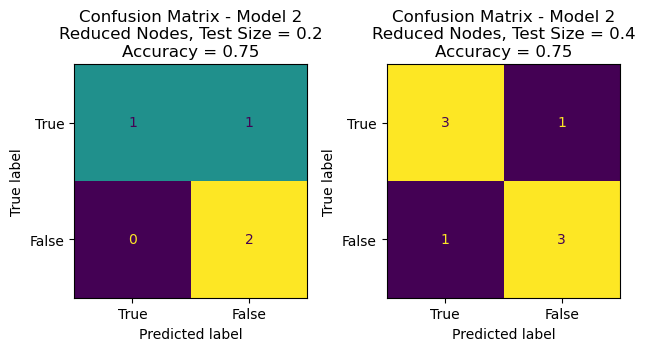

In [20]:
#Creating a confusion matrix to visualize the results
cm_3 = confusion_matrix(true_labels_3, predicted_labels_3)
cm_4 = confusion_matrix(true_labels_4, predicted_labels_4)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Confusion Matrix - Model 2\nReduced Nodes, Test Size = 0.2\nAccuracy = {}".format(match_rate_3))
ax[1].set_title("Confusion Matrix - Model 2\nReduced Nodes, Test Size = 0.4\nAccuracy = {}".format(match_rate_4))
ConfusionMatrixDisplay(cm_3, display_labels=[True, False]).plot(ax=ax[0], colorbar = False)
ConfusionMatrixDisplay(cm_4, display_labels=[True, False]).plot(ax=ax[1], colorbar = False)
plt.tight_layout()
plt.show()


**Analysis**  

Reducing the number of nodes in the LSTM and hidden layers represents a simpler model. Based on this, we expect that reducing the number of nodes will result in increased loss and lower accuracy. This is because fewer units have a reduced capacity to capture intricate patterns and dependencies in sequential data.

In the case of reduced node models we see varying results for the different splits. In the case of the 80/20 split (left), accuracy was reduced by 25% (from 1.0 to 0.75) and the test loss was much greater (4.47 e-07 in Model 1, compared to 1.4791 in Model 2). For the 60/40 split the accuracy remains the same (0.75) however the confusion matrix has a different distribution. In the case of Model 2 with reduced nodes, the model misclassifies two instances, 1 false positive and 1 false negative. Interestingly, the test loss for this model also decreases substantially (from 2.9782 to 0.4307). This may be a reflection of the   

It is also worth noting that the training results appeared to have a lower accuracy. In the case of Model 1 in Exercise 1 above, the model appears to reach 100% accuracy around the sixth epoch. In the case of the reduced node Model, it only obtains 100% accuracy (or nearly) around the tenth epoch.  


### Exercise 3 - Dropout

In [21]:
#Building a model with an increased amount of dropout
#Dropout increased to 0.7
def build_alt_model_2():
    model = models.Sequential()    
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.
    
    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    
    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))  
    model.add(layers.Dropout(0.7))
    model.add(layers.Dense(256,activation='relu'))    
    model.add(layers.Dropout(0.7))
    model.add(layers.Dense(512,activation='relu'))
    
    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='softmax'))
    
    opt = Adam(learning_rate=0.002)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    # this shows the network structure 
    model.summary()
    
    return model

In [22]:
model_5 = build_alt_model_2()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 256)          470016    
                                                                 
 lstm_9 (LSTM)               (None, 256)               525312    
                                                                 
 dense_16 (Dense)            (None, 512)               131584    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 512)              

In [23]:
print("Training the model with testing split of {}%, dropout = 0.7". format(test_sizes[1]*100))
model_5.fit(X_train2, y_train2, epochs=10, batch_size=len_train2)

Training the model with testing split of 40.0%, dropout = 0.7
Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.7079 - accuracy: 0.4167
Epoch 2/10
1/1 [==============================] - 0s 265ms/step - loss: 0.6862 - accuracy: 0.4167
Epoch 3/10
1/1 [==============================] - 0s 218ms/step - loss: 0.7214 - accuracy: 0.5833
Epoch 4/10
1/1 [==============================] - 0s 211ms/step - loss: 0.6127 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 246ms/step - loss: 0.5427 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 233ms/step - loss: 0.6017 - accuracy: 0.5833
Epoch 7/10
1/1 [==============================] - 0s 246ms/step - loss: 0.5074 - accuracy: 0.6667
Epoch 8/10
1/1 [==============================] - 0s 247ms/step - loss: 0.4949 - accuracy: 0.8333
Epoch 9/10
1/1 [==============================] - 0s 191ms/step - loss: 0.5203 - accuracy: 0.7500
Epoch 10/10
1/1 [==============================] - 0s 198ms

In [24]:
print("Testing the model with testing split of {}%, dropout = 0.7". format(test_sizes[1]*100))
test_loss, test_acc = model_5.evaluate(X_test2, y_test2, batch_size=len_train2)

y_pred_5 = model_5.predict(X_test2)
predicted_labels_5 = np.argmax(y_pred_5, axis=1)
true_labels_5 = np.argmax(y_test2, axis =1)

matches_5 = (predicted_labels_5 == true_labels_5)    
print('Total of matches: %d' % (matches_5.sum()))

match_rate_5 = matches_5.sum() / float(len(matches_5))
print('Match rate: %.2f' % (match_rate_5))

Testing the model with testing split of 40.0%, dropout = 0.7
1/1 [==============================] - 1s 1s/step
Total of matches: 5
Match rate: 0.62


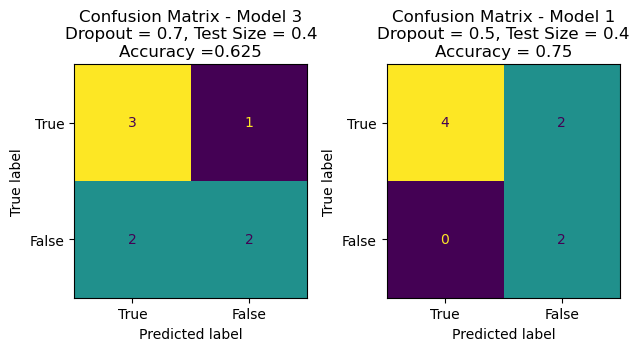

In [25]:
cm_5 = confusion_matrix(true_labels_5, predicted_labels_5)

fig, ax = plt.subplots(1, 2)
ax[0].set_title("Confusion Matrix - Model 3\nDropout = 0.7, Test Size = 0.4\nAccuracy ={}".format(match_rate_5))
ax[1].set_title("Confusion Matrix - Model 1\nDropout = 0.5, Test Size = 0.4\nAccuracy = {}".format(match_rate_2))
ConfusionMatrixDisplay(cm_5, display_labels=[True, False]).plot(ax=ax[0], colorbar = False)
ConfusionMatrixDisplay(cm_2, display_labels=[True, False]).plot(ax=ax[1], colorbar = False)
plt.tight_layout()
plt.show()

**Analysis**  

Dropout is a technique which 'removes' nodes from a neural net. The purpose of this is to reduce the amount of overfitting by allowing the model to 'learn' statistical noise. Depending on the dataset, increasing dropout can help the model generalize its results (i.e. improving testing accuracy). However, if too many nodes are removed, the model may become overly simplified and we encounter the same problem as exercise 2 where the model may be unable to capture the intricacies of the data.   

In the case of our dataset, we see that increasing the dropout from 0.5 to 0.7 leads to decreased accuracy and increased loss values. The confusion matrix on the left refers to the increased dropout model whereas the one on the right is from the original model. We can see that in the case of increased dropout, the model correctly identifies one less test sample, and there is a increase in both types of errors. Looking at training accuracy, similar to Exercise 2, we see that this model does not reach 100% accuracy in the ten iterations, which likely leads to the lower testing accuracy.  

## Conclusion 

In this lab, we applied machine learning principles to recognize hand gestures based on coordinates identified by the Leap Motion device. The initial step involved preprocessing the data, followed by its division into training and testing sets. Two scenarios were explored, with different splits: one with 60% of samples per gesture for training and 40% for testing, and another with 80% for training and 20% for testing.

Upon comparing the classifier evaluations, we saw that the split containing a higher proportion of training data led to a 20% increase in test accuracy. This outcome was attributed to the model having a more substantial dataset to familiarize itself with.

Furthermore, adjustments to the number of units within each LSTM layer revealed that reducing the units resulted in increased loss and decreased accuracy. Fewer units have a diminished capacity to capture intricate patterns and dependencies in the data. Additionally, altering the dropout value from the original 0.5 to 0.7 showed a decrease in accuracy and an increase in loss.

These exercises demonstrate the significant impact of parameter adjustments on model accuracy. Such techniques can be further utilized to recognize not only the type of gesture but also the identity of the subject performing the gesture.